## 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

## 2. Load Data

I am using FanGraphs' hitters dataset from their leaderboards tool. All data was accumulated between Opening Day and the morning of June 25, 2025. This data is compiled by FanGraphs and Baseball Savant and is publicly available online for free. This dataset contains 160 observations with 69 features. Columns include counting stats, expected stats, rate stats, and more.

In [2]:
df = pd.read_csv("2025_fg_leaderboard.csv")

## 3. Clean Data

To begin, I am converting all percentages to floating point numbers before proceeding.

In [3]:
# convert percentages to float

percent_cols = ["Hard%", "FB%", "Barrel%", "HardHit%"]

for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype(float)


## 4. Select Features and Target Variable

For feature selection, I am choosing a variety of features that would likely have some effect on home run prediction. I am using my existing knowledge of baseball and baseball analytics to figure out which features I should be using. Many of the features in my dataset pertain to non-power statistics, such as walk rate, baserunning metrics, and defensive metrics. While these may loosely relate to power (a lot of power hitters are less productive on defense), that is not always the case, so I made the decision to hand-pick features. 

Ultimately, I selected the following 16 features to predict home run total. Most of these features are statistics that indicate a player's ability to reach base when they put the ball in play, accrue total bases, hit the ball hard, hit the ball squarely, and hit the ball in the air. These are all requirements for a home run, so I am confident in using them as selected features to predict player home run totals.

Importantly, all players in this dataset are "qualified" (they meet MLB's playing time requirement to be statistically relevant), which means I am less likely to have fluky outliers, such as a player who only had one at-bat and managed to hit a home run with a low exit velocity. 

In [4]:
advanced_features = [
    "ISO", "BABIP", "SLG", "wOBA", "wRC+", "BsR", "Off", 
    "OPS", "xBA", "xSLG", "Hard%", "FB%", "EV", "LA", "Barrel%", "HardHit%"]
target = "HR"

df = df[advanced_features + [target]].dropna()

## 5. Prepare Decision Tree Implementation

For my decision tree, I want to classify players' home run totals as high or low. Since the season is only halfway complete, I am setting the threshold at 10 HR. If a player has less than 10 HR, they are a low home run total player. If they have 10 or more, they are a high home run total player. 

In [18]:
df = df[advanced_features + ["HR"]].dropna()
df["High_HR"] = (df["HR"] >= 10).astype(int)

X = df[advanced_features].values
y = df["High_HR"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

## 6. Decision Tree Implementation

F1 Score: 0.7429


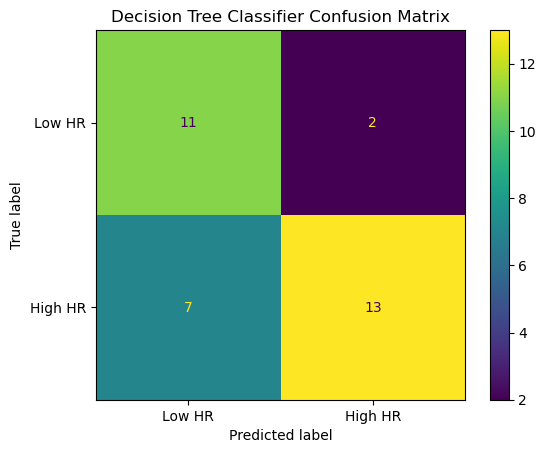

In [22]:
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    display_labels=["Low HR", "High HR"]
)
plt.title("Decision Tree Classifier Confusion Matrix")
plt.show()

The decision tree classifier seems to do a good (but not great) job at classifying players as low and high HR total players. True low HR players are mostly classified correctly (84.6% accuracy), but true high HR players are not classified as correctly (65.0% accuracy). Since both accuracy rates are above 50%, I feel as though I made solid progress here, but the classifier has plenty of room for improvement and could be refined to achieve even greater accuracy. Still, I do have confidence in its ability to classify players. 

## 7. Implement Train/Test for Regression

In [25]:
X = df[advanced_features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg_tree = DecisionTreeRegressor(max_depth=4)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

## 8. Predict

In [26]:
y_pred = reg_tree.predict(X_test)

## 9. Stats and Visualization

MSE: 5.9477
R: 0.9004
R^2: 0.8108


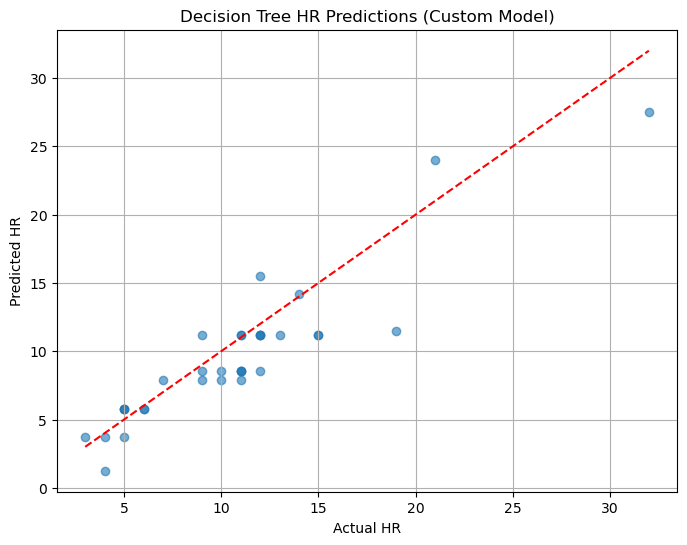

In [27]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r = np.sqrt(r2)

print(f"MSE: {mse:.4f}")
print(f"R: {r:.4f}")
print(f"R^2: {r2:.4f}")

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel("Actual HR")
plt.ylabel("Predicted HR")
plt.title("Decision Tree HR Predictions (Custom Model)")
plt.grid(True)
plt.show()

This scatterplot compares actual home run totals to the predictions from my decision tree model. Included within the plot is a line of best fit (dashed red line) which shows a perfect fit of actual vs. predicted. In other words, if every home run total was predicted correctly by the decision tree model, every blue plotted point would fall exactly along the red dashed line. 

My MSE of 5.9 leaves room for improvement, but I feel better about my model given the 0.81 R^2 score and 0.9 R score. 

The R^2 value of 0.81 means that 81% of the variation in home run totals among players can be explained by the model's input features.

## 10. Residuals

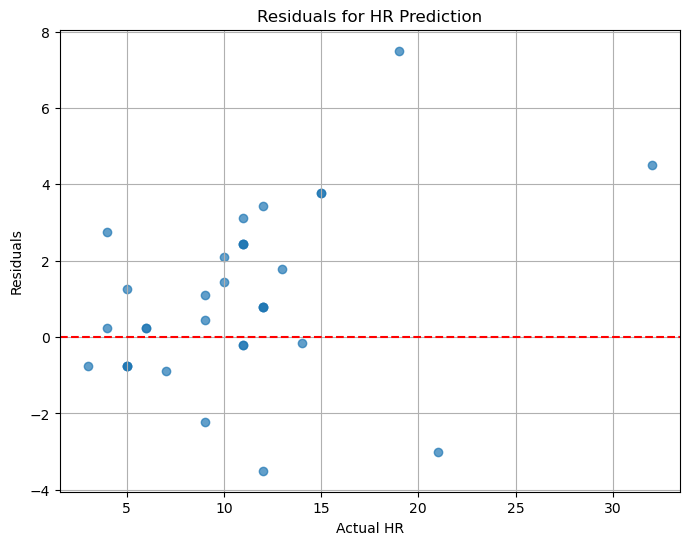

In [28]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual HR")
plt.ylabel("Residuals")
plt.title("Residuals for HR Prediction")
plt.grid(True)
plt.show()

The above visual shows the residuals for my exploration into home run totals. In other words, it plots the difference between actual and predicted home run totals among qualified MLB players. This plot does not really show the residuals randomly scattered around 0, as desired. Instead, we see that there are more residuals above 0 and less below 0. There also appear to be at least 1-2 outlier residuals. 

# 11. Model Complexity

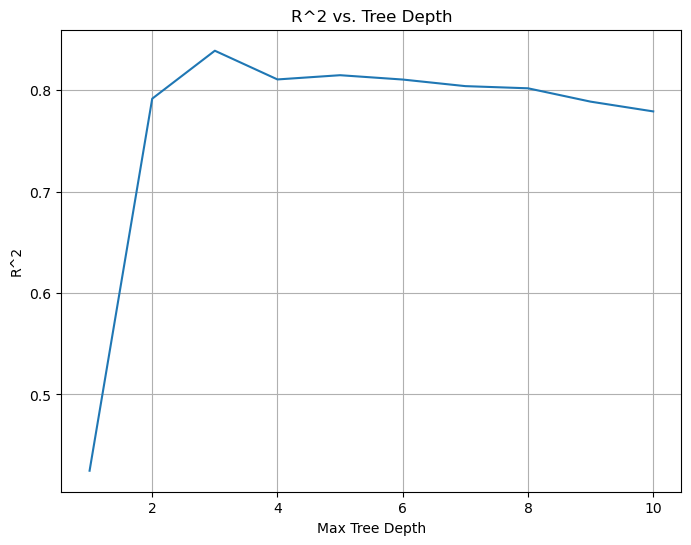

In [29]:
depths = range(1, 11)
r2_scores = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, pred))

plt.figure(figsize=(8, 6))
plt.plot(depths, r2_scores)
plt.xlabel("Max Tree Depth")
plt.ylabel("R^2")
plt.title("R^2 vs. Tree Depth")
plt.grid(True)
plt.show()

This plot tracks the regression tree model's R^2 score trend as max tree depth increases. The R^2 score seems to peak around depth 3 before plateauing (or even slightly decreasing). 